In [1]:
import pandas as pd
import numpy as np
import lattice.paths as paths
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from pathlib import Path
import time

    
def aggregate_data(dataset: Union[str,Path]):
    data = dict()
    for path in dataset.iterdir():
        df = pd.read_parquet(path)
        df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
        data[path.name.split('.')[0]] = df.iloc[1:]
    return data

## Loading Data

In [2]:
dirs = list(paths.data.iterdir())
print(dirs[1])
data = aggregate_data(dirs[1])

/home/magi/projects/lattice/lattice/data/365_days_900_seconds


## Inspecting Correlations

In [3]:
df = pd.DataFrame()
for market in data:
    df[market] = data[market].log_ret

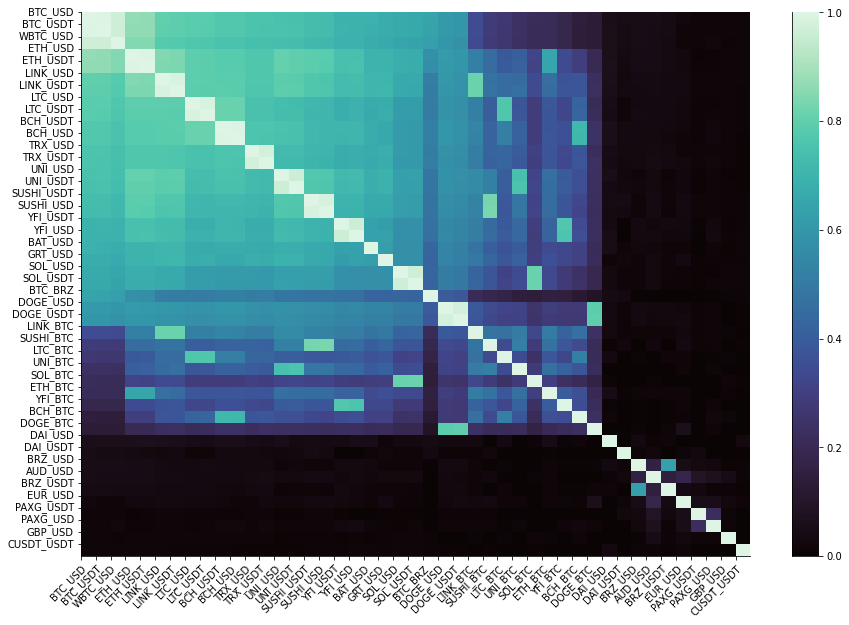

In [4]:
N = 45
S = df.corr()
labels = S['BTC_USD'].sort_values(ascending=False).index[:N]
S = S[labels].loc[labels]
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(S, vmin=0, vmax=1, cmap='mako')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(
    ax.get_xticklabels(), 
    rotation=45, 
    ha="right",
    rotation_mode="anchor"
)
sns.despine()
plt.show()

# Experimentation

In [107]:
import lattice.paths as paths

class LocalMarket:
   
    def __init__(self, config) -> None:
        self.__dict__.update(config['market'])
        self.data = self._load_data()
        self.T = self.data['BTC_USD'].shape[0]
        self.time = 0
          
    def _process_features(self, df: pd.DataFrame) -> None:
        """
        Note later on that the config can contain the feature classes
        and that they can be called through a feature registry instead of 
        having the processing logic hard coded.
        """
        df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
        
    def to_timestamp(self, iso_time: str):
        return datetime.datetime.fromisoformat(iso_time).timestamp()*1000
        
    def _load_data(self):
        t0,t1 = list(map(self.to_timestamp, self.window))
        data_dir = paths.data/self.dataset
        data = dict()
        for path in data_dir.iterdir():
            asset_name = path.name.split('.')[0]
            if asset_name in self.assets:
                df = pd.read_parquet(path)
                df = df.query('@t0 <= time < @t1')
                self._process_features(df)
                data[asset_name] = df.iloc[1:]
        return data
    
    def get_state(self):
        prices = dict()
        features = []
        for name in self.assets:
            x = self.data[name].iloc[self.time]
            features.append(x['log_ret'])
            prices[name] = x['close']
        self.time+=1
        done = True
        if self.time < 1000:#self.T:
            done = False
        return done, prices, np.array(features)

In [141]:
from dataclasses import dataclass

class LocalWallet:
    
    def __init__(self, config):
        self.__dict__.update(config['wallet'])
        self.history = []
    
    def update_balance(self, order):
        asset, underlying = order.asset.split('_')
        if asset in self.balances:
            self.balances[asset] += order.value
        else:
            self.balances.setdefault(asset, order.value)
        self.balances[underlying] -= order.value
        self.history.append(self.value)
            
    @property
    def value(self):
        usd = self.balances['USD']
        other = sum([amt for asset,amt in self.balances.items() if asset!='USD'])
        return usd-other
    
@dataclass
class Order:
    asset: str
    side: str
    price: float
    size: float
        
    @property
    def value(self):
        sign = 1 if self.side == 'BUY' else -1
        return sign*self.price*self.size
    
class Investor:

    def __init__(self, wallet, market, **kwargs) -> None:
        self.__dict__.update(kwargs)
        self.wallet = wallet
        self.market = market
        self.orders = dict()

    def place_order(self, order: Order):
        self.wallet.update_balance(order)
        self.orders.setdefault(order.asset, []).append(order)
        
    def evaluate_market(self):
        # Operates on abstract markets but is customizable
        # get_state() method
        pass

In [5]:
config = {
    'market':{
        'dataset': '365_days_60_seconds',
        'window': ['2022-01-01', '2022-03-01'],
        'assets': ['BTC_USD']
    },
    'wallet':{
        'balances':{'USD': 10000}
    } 
}

In [143]:
market = LocalMarket(config=config)
wallet = LocalWallet(config=config)
investor = Investor(wallet, market)

/tmp/ipykernel_318/514412509.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))


In [145]:
def evaluate_market(self):
    done, prices, features = self.market.get_state()
    orders = [
        Order(name, 'BUY', prices[name], size),
        Order(name, 'SELL', prices[name], size)
    ]
    new_order = np.random.choice(orders)
    investor.place_order(new_order)

SyntaxError: invalid syntax (3923958586.py, line 1)

In [144]:
done = False
name = 'BTC_USD'
size = 0.001
while not done:
    done, prices, features = market.get_state()
    orders = [
        Order(name, 'BUY', prices[name], size),
        Order(name, 'SELL', prices[name], size)
    ]
    new_order = np.random.choice(orders)
    investor.place_order(new_order)

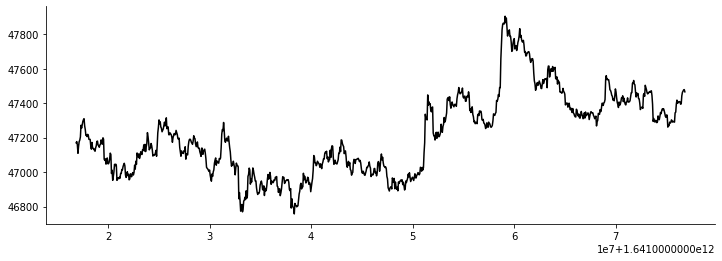

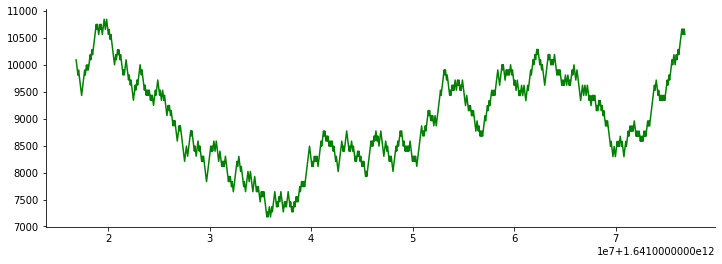

In [140]:
btc = market.data['BTC_USD'].iloc[:1000]
history = investor.wallet.history
plt.figure(figsize = (12,4))
plt.plot(btc.time, btc.close, color='k')
sns.despine()
plt.show()
plt.figure(figsize = (12,4))
plt.plot(btc.time, history, color='g')
sns.despine()
plt.show()

In [4]:
from lattice.investor.investor import Investor, BernoulliInvestor
from lattice.investor.market import LocalMarket
from lattice.investor.wallet import LocalWallet



config = {
    'market':{
        'dataset': '365_days_60_seconds',
        'window': ['2022-01-01', '2022-03-01'],
        'assets': ['BTC_USD']
    },
    'wallet':{
        'balances':{'USD': 10000}
    } 
}

market = LocalMarket(config)
wallet = LocalWallet(config)
investor = Investor(wallet, market)

In [5]:
"""
Want to be able to do live paper trading as well!!!
"""

local_bot = BernoulliInvestor(wallet, market)

In [6]:
local_bot.evaluate_market()

{'BTC_USD': 47170.0}


TypeError: Can't instantiate abstract class Order with abstract methods place